In [1]:
# torch imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.jit import script, trace

# other python libraries 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from math import floor
from tqdm import tqdm

In [2]:
print(f'torch version is: {torch.__version__}')

if torch.cuda.is_available():
    print('GPU is available')
else:
    print('CPU is available')
    
print(f'CUDA version is: {torch.version.cuda}')

torch version is: 1.7.1
GPU is available
CUDA version is: 11.0


In [3]:
# define preprocessing 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [4]:
bs = 64

In [5]:
PATH = Path('/data/building_damage')

In [6]:
train_set = ImageFolder(root = PATH/'train', transform = transform)

test_set = ImageFolder(root = PATH/'test', transform = transform)

In [7]:
len(train_set), len(test_set)

(10000, 2000)

In [8]:
train_loader = DataLoader(train_set, batch_size = bs, shuffle = True)

test_loader = DataLoader(train_set, batch_size = bs, shuffle = True)

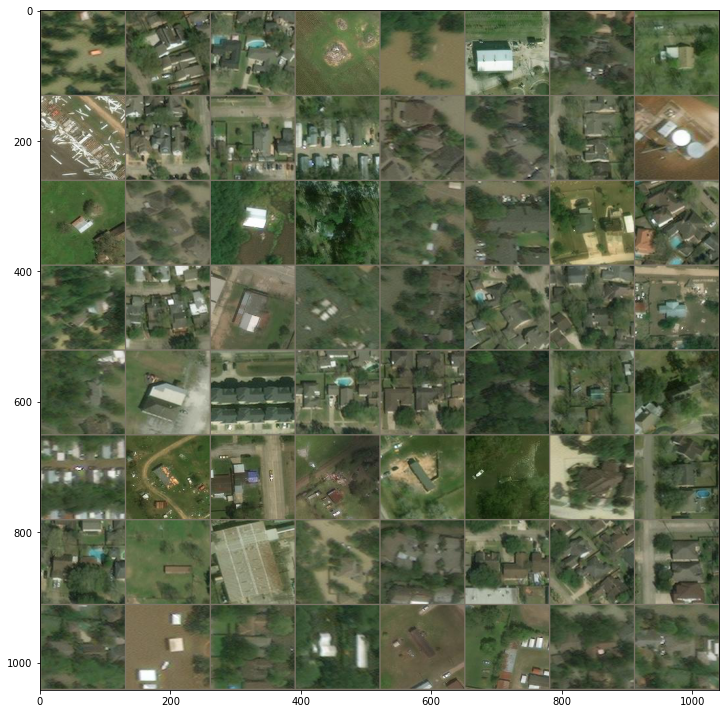

In [9]:
def imshow(inp, size):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose(1,2,0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(size))
    plt.imshow(inp)
    
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, size = (12.5,12.5))

In [10]:
def conv_output(n_in, p, k, s):
    '''
    n_in: number of input features 
    n_out: number of output features
    k: convolution kernel size
    p: convolution padding size
    s: convolution stride size
    '''
    n_out = floor((n_in + 2*p - k) / s) + 1
    return n_out

In [11]:
conv_output(n_in=119, p=0, k=2, s=1)

118

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) 
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=10092, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=2)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
net = Net()

In [14]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10092, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [15]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 3, 5, 5])


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net.to(device)
print(device)

cuda


In [18]:
def train(EPOCHS):
    train_loss = 0.0
    for epoch in range(EPOCHS):
        for (inputs, targets) in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            pred = net(inputs)
            # calculate loss
            loss = criterion(pred, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            train_loss = loss.item() * inputs.size(0)
            
        with torch.no_grad():
            for (inputs, targets) in tqdm(test_loader):
                inputs, targets = inputs.to(device), targets.to(device) 
                # compute the model output
                pred = net(inputs)
                # calculate loss
                loss = criterion(pred, targets)
                test_loss = loss.item() * inputs.size(0)
        
        print(f'Epoch {epoch} / {EPOCHS-1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Test Loss: {test_loss / len(test_loader)}')

In [19]:
train(2)

  1%|▏         | 2/157 [00:00<00:08, 18.75it/s]

Epoch 0 / 1 		 Training Loss: 0.06513053140822489 		 Test Loss: 0.07081707875440076


100%|██████████| 157/157 [00:05<00:00, 30.41it/s]

Epoch 1 / 1 		 Training Loss: 0.05152143490542272 		 Test Loss: 0.04890335593253944
